In [1]:
%matplotlib inline
import pickle
import scrapy
import string
from nltk import PunktSentenceTokenizer
import re
import gensim
LabeledSentence = gensim.models.doc2vec.LabeledSentence
from gensim.models import Doc2Vec
import gensim.models.doc2vec
import random
import numpy as np
from operator import itemgetter

from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import json

Couldn't import dot_parser, loading of dot files will not be possible.


## Pre-process data
#### load scraped articles

In [2]:
data = []
with open('../data/gizmodo_items_article.json') as f:
    for line in f:
        data.append(json.loads(line)) 

In [3]:
#create dict of links

url_dict = {}
for r in xrange(len(data)):
    url_dict[r] = data[r]['url']
    
with open('dump_urls.json', 'wb') as f:
     json.dump(url_dict,f)


In [4]:
#get keywords
##take out trailing spaces in keywords and lower
for r in xrange(len(data)):
    for w in xrange(len(data[r]['keywords'])):
        data[r]['keywords'][w] = data[r]['keywords'][w].strip()
        data[r]['keywords'][w] = data[r]['keywords'][w].lower()
    
keywords = []
for r in data:
    keywords.append(r['keywords'])

#### clean up article text

In [5]:
#combine article text and clean
def clean_text(article_text):
    article_text = ' '.join(article_text)
    article_text = article_text.lower()
    article_text = article_text.encode('ascii', errors = 'ignore')
    #pad punctuation with spaces
    article_text = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", article_text)
    return article_text.split()

In [6]:
#construct training set for doc2vec. 
#this returns a list of [article text, <article_label>]
#and a dictionary of article labels and the corresponding titles.

def construct_training(scraped):
    training_set = []
    article_dict = {}
    article_titles = []
    for l in xrange(len(scraped)):
        article = scraped[l]['body_text']
        article = clean_text(article)
        training_set.append(LabeledSentence(article, ['ARTICLE_%s' % l]))
        article_dict['ARTICLE_%s' % l] = scraped[l]['title']
        article_titles.append(scraped[l]['title'])
    return training_set, article_dict, article_titles

#### construct training set:
The input to Doc2Vec is an iterator of LabeledSentence objects. Each such object represents a single sentence, and consists of two simple lists: a list of words and a list of labels:



In [9]:
#scraped data
training, article_dict, article_titles = construct_training(data)

In [10]:
#fix titles
for i in xrange(len(article_titles)):
    article_titles[i] = article_titles[i].encode('ascii', errors = 'ignore')
    punctuation = string.punctuation.replace('-','').replace('+','').replace('(','').replace(')','').replace(',','')
    article_titles[i] = article_titles[i].encode('utf-8').translate(None, punctuation)

## doc2vec models

From rare-technologies.com/doc2vec-tutorial/ :
"One caveat of the way this algorithm runs is that, since the learning rate decrease over the course of iterating over the data, labels which are only seen in a single LabeledSentence during training will only be trained with a fixed learning rate. This frequently produces less than optimal results. I have obtained better results by iterating over the data several times and either randomizing the order of input sentences, or manually controlling the learning rate over the course of several iterations."

In [12]:
#model
def doc2vec_model(ALPHA, MIN_ALPHA, TRAINING, SIZE= 300):
    model = Doc2Vec(alpha= ALPHA, min_alpha= MIN_ALPHA, workers = 4, size = SIZE)  # use fixed learning rate
    model.build_vocab(TRAINING)
    for epoch in range(10):
        model.train(TRAINING)
        model.alpha -= 0.002  # decrease the learning rate
        model.min_alpha = model.alpha  # fix the learning rate, no decay
    return model


In [ ]:
#scraped data model
ALPHA = 0.025
MIN_ALPHA = 0.025
TRAINING = training
model = doc2vec_model(ALPHA, MIN_ALPHA, TRAINING)
model.save('d2v_scraped_articles.p')

In [11]:
#scraped data model
model = Doc2Vec.load('d2v_scraped_articles.p')

In [ ]:
#tried 500 dim vector model to improve results but this didn't help.
TRAINING = training
ALPHA = 0.025
MIN_ALPHA = 0.025
model_2d_500dim = doc2vec_model(ALPHA, MIN_ALPHA, TRAINING, SIZE = 500)
model_2d_500dim.save('d2v_scraped_articles_500dim.p')

#### look at results:

In [13]:
#takes in e.g. sims[0][0]
#converts to digit to index training_set
def string_to_digit(string):
    digit = []
    for r in string:
        if r.isdigit():
            digit.append(r)
    return int(''.join(digit))

In [14]:
#print some stats about the most similar, median, and least similar articles for one article
def some_stats(model, article_dict, training_set):
    doc_id = np.random.randint(model.docvecs.count)  # pick random doc, re-run cell for more examples
    sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)
    print(u'TARGET (%d): «%s»\n' % (doc_id, ' '.join(training_set[doc_id].words)))
    print ("TARGET",article_titles[doc_id])
    print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
    for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
        print label
        print index
        print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(training_set[string_to_digit(sims[index][0])].words)))
        print ("title",article_dict[sims[index][0]])

In [15]:
some_stats(model, article_dict, training)

TARGET (1374): «a team of researchers has happened upon several hundred footprints left by middle jurassic dinosaurs at a coastal lagoon in scotland . the footprints measure around 70 centimetres across , which is larger than those that would have been left by t . rex , and date back around 170 million years . in fact , the team that discovered the prints reckon they were left by early sauropods large plant eating dinosaurs that weighed over 20 tonnes and could be as tall as a 7-storey building . while other large areas of dinosaur footprints have been found in the past , this is the largest to be identified in scotland and should help researchers better understand how early sauropods moved . stephen brusatte , one of the researchers , explains to new scientist that these dinosaurs werent swimmers but they would have been moving around knee-deep in this brackish lagoon . amusingly , brusatte stumbled across the prints by accident , when returning to his car after an unsuccessful day of

## Dimensionality Reduction
Tried more than just tSNE, but not shown in this notebook. tSNE method shown worked best

In [16]:
#function to get the closest neighbors for an article
from sklearn.neighbors import NearestNeighbors
def return_closest(article_idx, articles, article_titles, model, n_neighbors = 3):
    neigh = NearestNeighbors(n_neighbors = n_neighbors)
    neigh.fit(articles)
#     result = neigh.kneighbors(articles[article_idx])
    for r in np.asarray(neigh.kneighbors(articles[article_idx])[1][0]):
        print (r, article_titles[r], model.docvecs.similarity(article_idx, r))
    return neigh.kneighbors(articles[article_idx])

#this function gets the original closest neighbors for an article
def orig_closest(article_idx, model, top):
    sims = model.docvecs.most_similar(article_idx, topn=top)
    for x in sims:
        print article_dict[x[0]]
    return sims

### 2D

In [ ]:
#init with pca method and do exact method
tsne_model = TSNE(n_components=2, random_state=0, verbose = 1, init= "pca", method = "exact")
tsne_articles_2D = tsne_model_verb2.fit_transform(model.docvecs)

In [17]:
tsne_articles_2D = pickle.load(open("all_2d_exact_tsne.p", "rb"))

### 3D

In [ ]:
tsne_model_exact_3d = TSNE(n_components=3, random_state=0, verbose = 2, init= "pca", method = "exact")
tsne_articles_exact_3d = tsne_model_exact_3d.fit_transform(model.docvecs)

In [18]:
tsne_articles_3D = pickle.load( open("all_3d_exact_tsne.p", "rb")) 

## Take the "top" articles
### go through each article and find its most similar article with similarity score.

### distribution of cosine similarities

In [67]:
#for each article, find the cosine similarity to each other article
cosine_similarities = []
for r in xrange(8000):
    for t in xrange(r+1,8000):
        cosine_similarities.append(model.docvecs.similarity(r,t))

In [72]:
l = [1,2,2,3]

In [75]:
min(cosine_similarities)

-0.36747929014079161

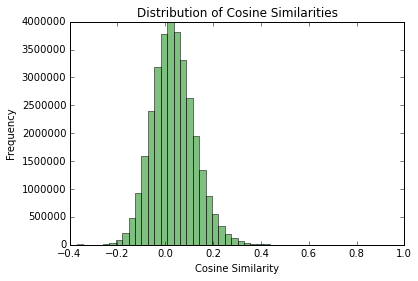

In [87]:
plt.hist(cosine_similarities, 50, facecolor='green', alpha=0.5)
plt.title('Distribution of Cosine Similarities')
plt.ylabel('Frequency')
plt.xlabel('Cosine Similarity')
plt.savefig('similarities_hist.png')

In [19]:
#store each article with its highest matching pair and the score
top_scores = []
for art_idx in xrange(len(model.docvecs)):
    top = model.docvecs.most_similar(art_idx, topn = 1)
    top_scores.append((art_idx, string_to_digit(top[0][0]), top[0][1]))

In [20]:
# for a,b,c in sorted(top_scores, key = itemgetter(2), reverse = True):
#     print a,b,c
#     print article_titles[a]
#     print article_titles[b]

In [20]:
# first_idx has the top indices
top_sorted = sorted(top_scores, key = itemgetter(2), reverse = True)
first = top_sorted[:1000]
first_idx = []
for k,v,w in first:
    first_idx.append(k)
    

### Cluster top 1k articles

### 2D

In [21]:
kmeans = KMeans(5, n_jobs=-1)
top_cluster_results = kmeans.fit_predict(tsne_articles_2D[first_idx])

In [37]:
len(top_cluster_results)

1000

/Users/ishteinbuk/anaconda/envs/ml/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


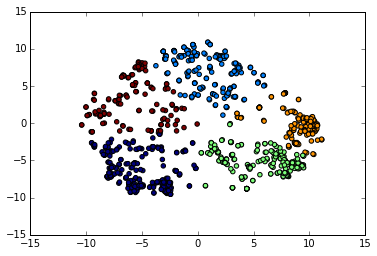

In [22]:
plt.scatter([x[0] for x in tsne_articles_2D[first_idx]], [x[1] for x in tsne_articles_2D[first_idx]], c=top_cluster_results)

In [23]:
# get dict of indices of results
count = 0
five_clusters = {}
for clust in xrange(5):
    five_clusters[clust] = []
for r in top_cluster_results:
    five_clusters[r].append(count)
    count += 1
        

In [24]:
def get_clusters(cluster, keywords_1000):
    return_cluster= {}
    for idx in cluster:
        for keyword in keywords_1000[idx]:
            if keyword in return_cluster:
                return_cluster[keyword] += 1
            else:
                return_cluster[keyword] = 1
    return return_cluster

def order_cluster(cluster):
    temp = []
    for k, v in sorted(cluster.items(), key = itemgetter(1), reverse = True):
        temp.append((k,v))
    return temp[:10]

keywords_1000 = np.asarray(keywords)[first_idx]

In [25]:
cluster_0 = get_clusters(five_clusters[0], keywords_1000)
cluster_1 = get_clusters(five_clusters[1], keywords_1000)
cluster_2 = get_clusters(five_clusters[2], keywords_1000)
cluster_3 = get_clusters(five_clusters[3], keywords_1000)
cluster_4 = get_clusters(five_clusters[4], keywords_1000)


In [53]:
top_cluster_results[806]

4

In [41]:
print (0,order_cluster(cluster_0))
print (1,order_cluster(cluster_1))
print (2,order_cluster(cluster_2))
print (3,order_cluster(cluster_3))
print (4,order_cluster(cluster_4))

(0, [(u'gizmodo', 201), (u'space', 103), (u'science', 67), (u'astronomy', 49), (u'nasa', 47), (u'earth &amp; space', 45), (u'new horizons', 33), (u'pluto', 31), (u'environment', 24), (u'astrobiology', 22)])
(1, [(u'gizmodo', 105), (u'io9', 81), (u'television', 57), (u'tv recap', 40), (u'star wars', 34), (u'movies', 34), (u'editor&#39;s picks', 33), (u'true crime', 25), (u'star wars: the force awakens', 25), (u'toybox', 17)])
(2, [(u'gizmodo', 177), (u'reviews', 49), (u'photography', 44), (u'android', 39), (u'smartphones', 35), (u'shootingchallenge', 34), (u'review', 31), (u'indefinitely wild', 29), (u'apple', 20), (u'samsung', 20)])
(3, [(u'field guide', 72), (u'gizmodo', 56), (u'android', 37), (u'apps', 27), (u'ios', 22), (u'google', 20), (u'tips', 19), (u'reviews', 18), (u'windows 10', 17), (u'apple', 15)])
(4, [(u'gizmodo', 117), (u'science', 47), (u'true crime', 30), (u'medicine', 20), (u'murder', 20), (u'biology', 14), (u'health', 10), (u'io9', 9), (u'animals', 8), (u'indefinitely

### 3D

In [27]:
kmeans = KMeans(5, n_jobs=-1)
top_cluster_results_3D = kmeans.fit_predict(tsne_articles_3D[first_idx])

In [32]:
tsne_articles_3D_1000 = tsne_articles_3D[first_idx]
tsne_articles_3D_1000_x = [x[0] for x in tsne_articles_3D_1000]
tsne_articles_3D_1000_y = [x[1] for x in tsne_articles_3D_1000]
tsne_articles_3D_1000_z = [x[2] for x in tsne_articles_3D_1000]

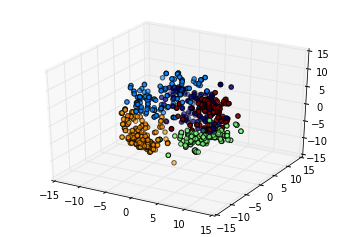

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_articles_3D_1000_x, tsne_articles_3D_1000_y, tsne_articles_3D_1000_z, c = top_cluster_results_3D)

In [34]:
count = 0
five_clusters_3D = {}
for clust in xrange(5):
    five_clusters_3D[clust] = []
for r in top_cluster_results_3D:
    five_clusters_3D[r].append(count)
    count += 1

In [35]:
cluster_0_3D = get_clusters(five_clusters_3D[0], keywords_1000)
cluster_1_3D = get_clusters(five_clusters_3D[1], keywords_1000)
cluster_2_3D = get_clusters(five_clusters_3D[2], keywords_1000)
cluster_3_3D = get_clusters(five_clusters_3D[3], keywords_1000)
cluster_4_3D = get_clusters(five_clusters_3D[4], keywords_1000)

In [48]:
top_cluster_results_3D[140]

3

In [42]:
print (0 ,order_cluster(cluster_0_3D))
print ( 1,order_cluster(cluster_1_3D))
print ( 2,order_cluster(cluster_2_3D))
print ( 3,order_cluster(cluster_3_3D))
print ( 4,order_cluster(cluster_4_3D))

(0, [(u'gizmodo', 96), (u'io9', 87), (u'television', 57), (u'true crime', 55), (u'tv recap', 40), (u'editor&#39;s picks', 36), (u'star wars', 31), (u'movies', 31), (u'star wars: the force awakens', 23), (u'murder', 21)])
(1, [(u'gizmodo', 159), (u'science', 57), (u'medicine', 24), (u'biology', 16), (u'urbanism', 15), (u'cities', 15), (u'environment', 12), (u'transportation', 12), (u'health', 11), (u'future earth', 11)])
(2, [(u'gizmodo', 144), (u'reviews', 45), (u'photography', 43), (u'android', 38), (u'shootingchallenge', 33), (u'smartphones', 33), (u'indefinitely wild', 29), (u'review', 27), (u'cameras', 16), (u'apple', 15)])
(3, [(u'gizmodo', 174), (u'space', 104), (u'science', 62), (u'astronomy', 49), (u'nasa', 48), (u'earth &amp; space', 46), (u'new horizons', 33), (u'pluto', 31), (u'image cache', 24), (u'astrobiology', 22)])
(4, [(u'gizmodo', 83), (u'field guide', 72), (u'android', 38), (u'apps', 28), (u'reviews', 22), (u'ios', 22), (u'windows 10', 20), (u'google', 20), (u'tips',